# 20. 근사 베이지안 계산
- **가장 복잡한 문제들에 사용하는 최후의 보루**
    - 다른 방법론에 비해 많은 연산 필요


In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

from utils import set_pyplot_params
set_pyplot_params()

<br>

## 20.01 신장 종양 문제

레딧의 한 포럼

> "나는 현재 신장암 4기인데, 이 암이 퇴역 전에 생긴 것인지 알고 싶습니다. 암 발견일자와 퇴역 일자를 알고 있다면, 이 병이 군에서 커졌을 확률이 50/50인지 알 수 있을까요? 퇴역일 기준으로 이 확률을 계산한다는게 가능한가요? 발견시 암 2기 진단을 받았고, 이 때 종양의 크기는 15.5cm X 15cm 크기였습니다"

<br>

#### 신장 종양은 천천히 자라고, 종종 무증상이어서 치료하지 않고 놔두는 경우가 있기에, 종양을 치료하지 않는 경우 환자의 종양을 여러 번 촬영한 후 성장 정도를 관측한다

[논문](https://pubs.rsna.org/doi/full/10.1148/radiol.2501071712)은 두 가지 형태로 성장률을 다루고 있다.

* 부피 배가 시간 (VDT) : 종양이 크기가 두 배가 되는 데 걸리는 시간

* 상호 배가 시간 (RDT) : 연간 종양 크기 배수


<br>

## 20.02. 단순성장 모델

#### 다음의 두 가지 가정을 기반으로 종양의 성장에 대한 단순한 모델을 생성

* 종양의 배가 시간은 일정한 상수

* 종양은 대략 구형을 띈다

#### 또한 다음의 두 시각을 정의

* `t1` : 질문자가 전역한 때

* `t2` : 종양이 발견될 때

- **이 경우, `t1`과 `t2`사이 시간은 약 9.0년**

    **종양의 지름은 `t1`때 1cm였고, `t2` 때의 크기를 추정하고자 할 때**


<br>

#### 종양은 구형이라는 가정하에, `t1`시기 부피 `v1`계산

In [2]:
import numpy as np

In [3]:
def calc_volume(diameter):
    
    """지름을 부피로 변환"""
    factor = 4 * np.pi / 3
    return factor * (diameter/2.0)**3

In [4]:
d1 = 1
v1 = calc_volume(d1)
v1

0.5235987755982988

<br>

#### 논무에 따르면, 부피 배가 시간의 중간값은 811이며, 이 값은 연간 배가 정도로 대응하면 0.45 RDT

In [5]:
median_doubling_time = 811
rdt = 365 / median_doubling_time
rdt

0.45006165228113443

<br>

#### `t1`과 `t2`사이의 시간동안 일어난 배수 계산

In [6]:
interval = 9.0
doublings = interval * rdt
doublings

4.05055487053021

<br>

#### `v1`과 배수를 통하여, `t2`때의 부피 `v2`계산

In [7]:
v2 = v1 * 2**doublings
v2

8.676351488087187

<br>

#### 주어진 부피에 대해 구의 지름을 계산

In [8]:
def calc_diameter(volume):
    
    """부피를 지름으로 변환"""
    factor = 3 / np.pi / 4
    return 2 * (factor * volume)**(1/3)

In [9]:
d2 = calc_diameter(v2)
d2

2.5494480788327483

#### `t1`때의 종양 지름이 1cm였고, 중간값 성장률을 따라 커졌다면, `t2`때의 종양 지름은 2.5cm

<br>

## 20.03. 보다 일반적인 모델

진단 시점의 종양 크기가 주어졌을 때, 이 크기가 연령별 대로 어떻게 다른지 확인하기 위해, 연령대별로 종양의 크기 분포를 통해 종양이 커지는 정도를 시뮬레이션


1.  성장률 분포로부터의 값을 추출

2.  구간의 끝에 있는 종양의 크기를 계산

3.  종양이 특정 최고치를 초과할 때까지 이 과정을 반복


<br>

#### 53명의 환자에 대한 RDT 추정값
- `rdt=1`이면, 종양은 1년에 부피가 $2$배 성장
- `rdt=2`라면, 종양은 1년에 부피가 $2^2$배 성장

In [10]:
import numpy as np
from empiricaldist import Pmf

In [13]:
rdts = [5.089,  3.572,  3.242,  2.642,  1.982,  1.847,  1.908,  1.798,
        1.798,  1.761,  2.703, -0.416,  0.024,  0.869,  0.746,  0.257,
        0.269,  0.086,  0.086,  1.321,  1.052,  1.076,  0.758,  0.587,
        0.367,  0.416,  0.073,  0.538,  0.281,  0.122, -0.869, -1.431,
        0.012,  0.037, -0.135,  0.122,  0.208,  0.245,  0.404,  0.648,
        0.673,  0.673,  0.563,  0.391,  0.049,  0.538,  0.514,  0.404,
        0.404,  0.33,  -0.061,  0.538,  0.306]

rdt_sample = np.array(rdts)
len(rdt_sample)

53

In [14]:
from utils import kde_from_sample

In [15]:
qs = np.linspace(-2, 6, num=201)
pmf_rdt = kde_from_sample(rdt_sample, qs)

In [17]:
from utils import decorate

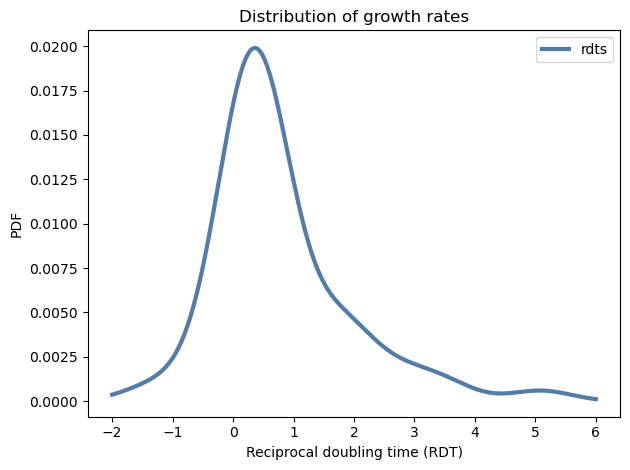

In [16]:
pmf_rdt.plot(label='rdts')

decorate(xlabel='Reciprocal doubling time (RDT)', ylabel='PDF', title='Distribution of growth rates')

<br>

## 20.04. 시뮬레이션

#### 작은 종양에서부터, 종양이 최대 크기가 될 때까지 여러 시간 구간에 대해 시뮬레이션 진행

**각 시간 구간의 시작점에, 성장률 분포에서 값을 하나 가져와서, 시간 구간이 끝날 때의 종양 크기를 계산**

- 245일로 구간을 나눔 (약 8개월)
- 시뮬레이션 초기 지름은 0.3cm
- 종양의 최고 크기는 20cm

In [39]:
interval = 245 / 365      # year
min_diameter = 0.3        # cm
max_diameter = 20         # cm

#### 초기 및 최대 부피 계산

In [45]:
v0 = calc_volume(min_diameter)
vmax = calc_volume(max_diameter)
v0, vmax

(0.014137166941154066, 4188.790204786391)

#### 시뮬레이션 진행
- 종양의 나이와 부피를 초기화한 후, 하나의 시간구간을 시뮬레이션 하는 반복문 실행

In [22]:
import pandas as pd

In [23]:
def simulate_growth(pmf_rdt):
    
    """종양성장 시뮬레이션"""
    age = 0
    volume = v0
    res = []
    
    while True:
        res.append((age, volume))
        if volume > vmax:
            break

        rdt = pmf_rdt.choice()
        age += interval 
        doublings = rdt * interval
        volume *= 2**doublings
        
    columns = ['age', 'volume']
    sim = pd.DataFrame(res, columns=columns)
    sim['diameter'] = calc_diameter(sim['volume'])
    return sim

In [47]:
np.random.seed(17)
sim = simulate_growth(pmf_rdt)
sim.head(3)

,age,volume,diameter
0,0.000000,0.014137,0.300000
1,0.671233,0.014949,0.305635
2,1.342466,0.019763,0.335441


In [48]:
sim.tail(3)

,age,volume,diameter
43,28.863014,1882.067427,15.318357
44,29.534247,2887.563277,17.667603
45,30.205479,4953.618273,21.149883


<br>

#### 101번의 시뮬레이션에 대한 시각화
- 각 가는 직선은 종양이 시간에 따라 성장하는 시뮬레이션 결과를 지름의 로그 단위로 나타냄
- 점선은 4cm, 8cm, 16cm를 표시

<br>

#### 16cm의 종양의 나이는 최소 10살, 최대ㅡ 40살, 보통 15에서 30살일 가능성이 높음

In [49]:
np.random.seed(17)

sims = [simulate_growth(pmf_rdt) for _ in range(101)]

In [50]:
import matplotlib.pyplot as plt

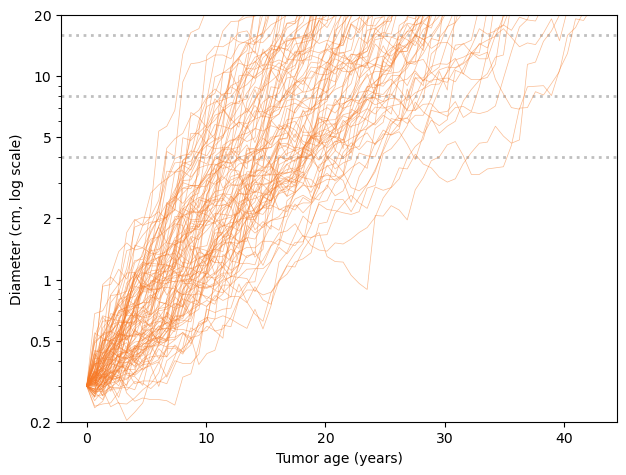

In [31]:
diameters = [4, 8, 16]
for diameter in diameters:
    plt.axhline(diameter, color='C5', linewidth=2, ls=':')

for sim in sims:
    plt.plot(sim['age'], sim['diameter'], color='C1', linewidth=0.5, alpha=0.5)
    
decorate(xlabel='Tumor age (years)', ylabel='Diameter (cm, log scale)', ylim=[0.2, 20], yscale='log')

yticks = [0.2, 0.5, 1, 2, 5, 10, 20]
plt.yticks(yticks, yticks);

#### 크기가 4, 8, 15 cm인 종양의 연령 분포

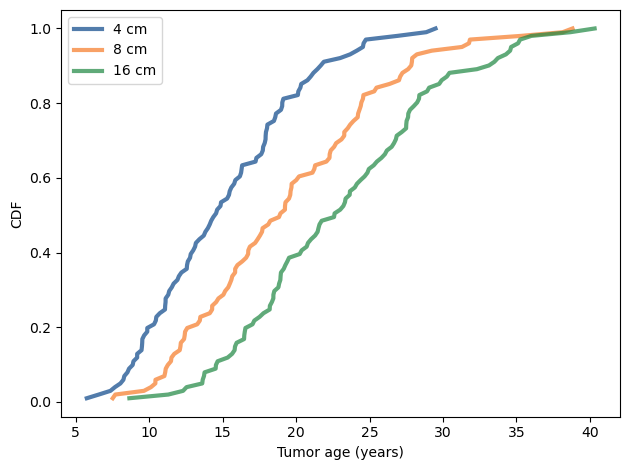

In [57]:
for diameter in diameters:
    ages = interpolate_ages(sims, diameter)
    cdf = Cdf.from_seq(ages)
    cdf.plot(label=f'{diameter} cm')
    
decorate(xlabel='Tumor age (years)', ylabel='CDF')

<br>

#### 시뮬레이션 결과를 사용해서, 각 종양이 주어진 지름에 도달할 때의 나이 계산

In [51]:
from scipy.interpolate import interp1d

In [52]:
def interpolate_ages(sims, diameter):
    
    """종양이 주어진 크기에 도달할 때의 나이를 추정"""
    ages = []
    for sim in sims:
        interp = interp1d(sim['diameter'], sim['age'])
        age = interp(diameter)
        ages.append(float(age))
    return ages

In [53]:
from empiricaldist import Cdf

In [54]:
ages = interpolate_ages(sims, 15)
cdf = Cdf.from_seq(ages)
print(cdf.median(), cdf.credible_interval(0.9))

22.31854530374061 [13.47056554 34.49632276]


- **15cm의 종양의 경우, 나이의 중간값은 약 22살이고,**

    **90% 신용구간은 13세에서 34세이며,**
    
    **이 종양이 생긴지 9년이 안 되었을 경우는 1%미만**

In [37]:
1 - cdf(9.0)

0.9900990099009901

<br>

#### 하지만 이 결과는 문제가 있을 수 있는 두 가지 모델링을 위한 판단에 기초

* 이 시뮬레이션에서, 각 시간 구간에서의 성장률은 이전 성장률과 독립적이다. 

    하지만 실제로는 이전에 빠르게 자란 종양은 이후에도 빠르게 자라는 경우가 많다.
    
    **즉, 성장률에는 시간에 따른 상관관계가 존재**
    
    <br>

* 선형 수치로 부피를 변환하는 과정에서, 종양이 거의 구형을 띈다고 가정함

<br>

#### 종양이 구형이라는 가정은 몇 cm밖에 안되는 종양의 경우 무난하게 쓸 수 있지만, 크기가 15.5cm X 15cm에 달하는 종양에 사용하기는 어려움
- 이 크기의 종양이 상대적으로 편평한 경우 약 6cm의 구와 동일한 부피


<br>

## 20.05. 근사 베이지안 계산

#### ABC의 기본 개념은 사전분포를 이용하여, 매개변수의 표본을 생성하고, 표본의 각 매개변수 쌍에 대한 시스템을 시뮬레이션

<br>

## 20.06. 세포 수 측정 (MCMC)

#### 맥주 양조 과정에 사용되는 물과 효모의 혼합물인 '효모 슬러리'에서의 세포 수 측정 과정

1. 우선 세포 수를 실제로 측정 가능한 수준이 될 정도의 낮은 집중도를 보일 때까지 슬러리를 희석
2. 적은 양의 표본을 직사각형 격자에 고정된 양의 액체를 담는 특수 현미경 슬라이드인 혈구계산판에 올림

<br>

#### 세포와 격자는 현미경으로 볼 수 있으며, 이를 통해 세포수를 기록

<br>

- 예를 들어, 세포 집중도를 알 수 없는 효모 슬러리가 있다고 할 때,

    셰이커에 1ml의 표본을 넣고 9ml의 물을 더 한 후 잘 섞어서 희석시킨다
    
    그리고 다시 희석시키고, 또 희석시킨다
    
    매번 희석할 때마다 10배씩 집중도가 낮아진다고 하면, 세 번 희석시키면 집중도가 1,000배 낮아짐
    
    <br>
    
- 그 후 희석된 표본을 5 X 5 격자에 0.0001ml을 담을 수 있는 혈구 계산판에 올린다

    이 격자에는 15개의 사각형이 있지만, 이 중 일부인 5개 정도만 조사한 후, 조사한 사각형의 총 세포수를 결과로 사용
    
<br>

#### 이 과정은 매우 단순하지만, 각 단계마다 오차가 발생할 소지가 존재

- 희석 과정에서, 액체는 측정 오차가 발생할 수 있는 피펫을 사용
- 혈구계산판의 액체 양은 사양에 따라 달라질 수 있음
- 표본 추출 과정의 각 단계에서, 무작위 변동성에 따라 세포의 수가 평균 이상일 수도, 이하일 수도 있음

<br>

#### 데이비슨-필론은 이런 오차를 나타내는 PyMC모델을 생성
- **격자에는 25개의 사각형이 있고,**

    **이 중 5개의 사각형에 대해서 세포 수를 측정**

    **이 때 총 세포수는 49**

In [58]:
total_squares = 25
squares_counted = 5
yeast_counted = 49

<br>

#### 추정하고자 하는 값인 효모의 집중도 `year_conc` 에 대한 사전분포를 정의
- `shaker1_vol` : 처음 셰이커에 넣은 물의 실제 부피

    - 9ml이여야 하지만, 실제 값은 표준편차 0.05ml 정도의 오차를 가짐
    
    <br>
- `shaker2_vol`과 `shaker3_vol`역시 오차를 가질 수 있음

In [60]:
import pymc3 as pm

In [61]:
billion = 1e9

In [62]:
with pm.Model() as model:
    yeast_conc = pm.Normal("yeast conc", mu=2 * billion, sd=0.4 * billion)

    shaker1_vol = pm.Normal("shaker1 vol", mu=9.0, sd=0.05)
    shaker2_vol = pm.Normal("shaker2 vol", mu=9.0, sd=0.05)
    shaker3_vol = pm.Normal("shaker3 vol", mu=9.0, sd=0.05)

<br>

#### 효모 슬러리에서 가져온 표본은 약 1ml로 예상하지만, 더 많거나 적을 수 있음
- **첫 번째 셰이커에서 가져온 표본과 두 번째 셰이커에서 가져온 표본에도 역시 비슷한 경우가 발생할 수 있음**

In [63]:
with model:
    yeast_slurry_vol = pm.Normal("yeast slurry vol", mu=1.0, sd=0.01)
    shaker1_to_shaker2_vol = pm.Normal("shaker1 to shaker2", mu=1.0, sd=0.01)
    shaker2_to_shaker3_vol = pm.Normal("shaker2 to shaker3", mu=1.0, sd=0.01)

<br>

#### 주어진 표본과 셰이커의 실제 부피를 사용해서, 효과적인 희석 정도인 `final_dilution`을 구현
- **이 값은 1,000이어야 하지만, 더 높거나 낮을 수 있음**

In [65]:
with model:
    dilution_shaker1 = (yeast_slurry_vol / (yeast_slurry_vol + shaker1_vol))
    dilution_shaker2 = (shaker1_to_shaker2_vol / (shaker1_to_shaker2_vol + shaker2_vol))
    dilution_shaker3 = (shaker2_to_shaker3_vol / (shaker2_to_shaker3_vol + shaker3_vol))
    
    final_dilution = (dilution_shaker1 * dilution_shaker2 * dilution_shaker3)

<br>

#### 세 번째 셰이커에서 가져온 표본을 혈구계산판 격자에 넣는 용량은 0.0001ml이여야 하지만, 더 많거나 적을 수 있기에, 
#### 혈구계산판 격자의 용량 `chamber_vol`
- **분산 정도를 나타내기 위해, 음의 값을 가지지 않는 감마분포를 사용**

In [66]:
with model:
    chamber_vol = pm.Gamma("chamber_vol", mu=0.0001, sd=0.0001 / 20)

<br>

#### 평균적으로, 격자 안의 세포 수는 `yeast_in_chamber` 실제 집중도와 최종 희석도의 격자 부피의 곱으로 표현되지만, 더 많거나 적을 수 있음
- **분산 정도를 나타내는 데 포아송분포를 사용**

In [67]:
with model:
    yeast_in_chamber = pm.Poisson("yeast in chamber", mu=yeast_conc * final_dilution * chamber_vol)

<br>

#### 실제 측정값 `count`는, 격자 안의 각 세포가 측정할 사각형에 들어갈 확률 `p=squares_counted/total_squares`를 매개변수로 가지는 이항분포를 따름
#### `observed=yeast_counted`로 갱신 $\rightarrow$ 사후결합분포 

In [68]:
with model:
    count = pm.Binomial("count", n=yeast_in_chamber, p=squares_counted/total_squares, observed=yeast_counted)

<br>

#### 매개변수별 사후분포, 사후결합분포 표본추출

In [103]:
model

In [69]:
options = dict(return_inferencedata=False)

In [70]:
with model:
    trace = pm.sample(1000, **options)

C:\Users\FORYOUCOM\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\FORYOUCOM\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [chamber_vol, shaker2 to shaker3, shaker1 to shaker2, yeast slurry vol, shaker3 vol, shaker2 vol, shaker1 vol, yeast conc]
>Metropolis: [yeast in chamber]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
The number of effective samples is smaller than 10% for some parameters.


<br>

#### `yeast_conc`의 사후주변분포
- 사후평균은 ml당 23억개 가량, 90% 신용구간은 18억에서 27억

In [71]:
posterior_sample = trace['yeast conc'] / billion
cdf_pymc = Cdf.from_seq(posterior_sample)
print(cdf_pymc.mean(), cdf_pymc.credible_interval(0.9))

2.275317054280632 [1.86815999 2.70133509]


<br>

## 20.07. 세포 수 측정 (ABC)

<br>

#### 매개변수별 사전분포 표본추출

In [72]:
with model:
    prior_sample = pm.sample_prior_predictive(10000)

In [78]:
len(prior_sample), prior_sample

(11,
 {'count': array([40, 39, 27, ..., 51, 33, 49]),
  'chamber_vol_log__': array([-9.18133351, -9.21515658, -9.16750146, ..., -9.14884739,
         -9.22158585, -9.12592874]),
  'yeast in chamber': array([186, 211, 149, ..., 287, 157, 245]),
  'shaker1 to shaker2': array([1.00012924, 0.99199673, 0.99601297, ..., 1.00142607, 1.00352011,
         0.98861955]),
  'shaker3 vol': array([8.9514577 , 9.03500158, 9.04090839, ..., 8.88535307, 9.03987841,
         8.96659095]),
  'yeast conc': array([1.81031589e+09, 1.99830797e+09, 1.51643511e+09, ...,
         2.37104407e+09, 1.61934788e+09, 2.14300738e+09]),
  'chamber_vol': array([1.02943166e-04, 9.95195371e-05, 1.04376974e-04, ...,
         1.06342303e-04, 9.88817520e-05, 1.08807669e-04]),
  'shaker2 vol': array([9.0104306 , 8.99480467, 9.04182071, ..., 9.00337855, 9.04064533,
         9.02740406]),
  'yeast slurry vol': array([0.98751361, 0.9974625 , 0.98620416, ..., 1.02593653, 1.00068612,
         1.01095716]),
  'shaker1 vol': array([8

<br>

#### `count`의 사전분포 평균

In [79]:
count = prior_sample['count']
print(count.mean())

39.9237


<br>

#### `count`의 사전분포 표본 중, 관측값 49와 일치하는 값의 인덱스 (249개)

In [80]:
mask = (count == yeast_counted)
mask.sum()

245

#### 효모 집중도 `yeast_conc`의, 위 인덱스에 해당하는 값들을 선택

In [81]:
posterior_sample2 = prior_sample['yeast conc'][mask] / billion

<br>

#### `yeast conc`의 사후주변분포 표본을 사용하여 CDF를 추정

In [82]:
cdf_abc = Cdf.from_seq(posterior_sample2)
print(cdf_abc.mean(), cdf_abc.credible_interval(0.9))

2.278250640922827 [1.86037826 2.71858362]


<br>

#### 사후평균과 신뢰구간은 MCMC로 했을 때 얻은 결괏값과 유사하지만
#### 표본 크기가 더 작다보니 ABC의 결과에 잡음이 더 많음

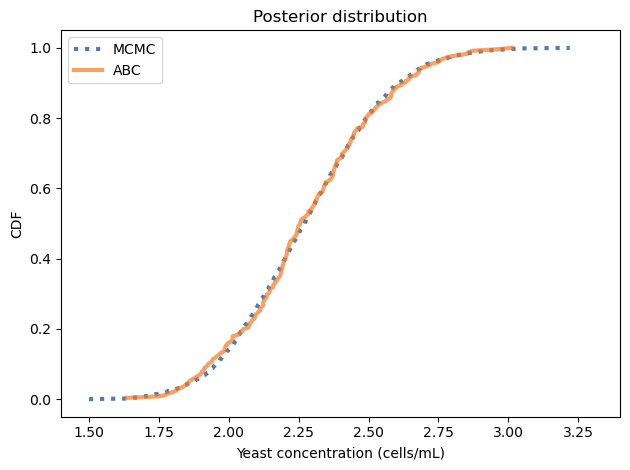

In [106]:
cdf_pymc.plot(label='MCMC', ls=':')
cdf_abc.plot(label='ABC')

decorate(xlabel='Yeast concentration (cells/mL)', ylabel='CDF', title='Posterior distribution', xlim=(1.4, 3.4))

<br>

## 20.08. 추정

#### 일반적으로 ABC는 다음의 특성을 가짐

1. 매개변수의 사전분포

2. 데이터를 생성하는 시스템 시뮬레이션

3. 시뮬레이션의 결괏값이 데이터와 일치하는 것을 받아들여야 하는 경우에 대한 기준

<br>

#### 신장 종양 문제는 나이에 대한 사전분포를 명시적으로 구하지 않았음
- 시뮬레이션이 나이와 종양 크기에 대한 결합분포를 생성하기 때문에, 결과에서 나이의 사후주변분포를 구할 수 있음

<br>

#### 효모 문제는 매개변수의 분포를 명시적으로 나타내었으나, 결과와 데이터가 정확히 일치하는 경우의 시뮬레이션만을 허용
- **사후분포 그 자체보다, 사후분포 표본을 활용한다는 점에서 결과는 보다 근사적**

    **하지만 일반적으로 결괏값이 데이터와 대략적으로 일치하는 시뮬레이션을 허용하는 근사 베이지안 계산에서는 근사적인 것이 아님**
    <br>
    
    - 결괏값이 관측값 49와 정확히 일치한 시뮬레이션만 받아들이고, 나머지는 기각하였음

        **$\rightarrow$ 10,000개의 시뮬레이션 중 일부 (249)개의 표본만이 남았으며, 이는 매우 비효율적**
    
        **$\rightarrow$ 결괏값이 49에 가까운 경우 '부분 접수'를 준다면, 시뮬레이션 결과를 더 활용할 수 있음**
        
        **이 때, 얼마나 가까워야 부분 점수를 받을 수 있으며, 점수는 얼마나 주어야 하는가?**
        
        <br>
        
        <hr>
        
    - **이항분포를 사용, 격자 안의 세포 수 `yeast in chamber`를 알고 있는 상태에서 최종 세포 수를 생성하는 데까지의, 시뮬레이션의 두 번째부터 마지막 단계까지를 백업**
        
        <br>

<br>

- **격자 안에 `n`개의 세포가 있다면, 각 세포는 측정되는 사각형 중 하나에 들어갈 것인가 아닌가에 따른 측정될 확률 `p`를 가짐**
        
        


In [107]:
n = prior_sample['yeast in chamber']
n.shape

(10000,)

In [114]:
n

array([186, 211, 149, ..., 287, 157, 245])

In [108]:
p = squares_counted/total_squares
p

0.2

<br>

#### 각 `n`의 값과 고정된 `p`값에 대해 `yeast_counted` 데이터의 가능도를 구하는 데 이항분포를 사용

In [109]:
from scipy.stats import binom

In [110]:
likelihood = binom(n, p).pmf(yeast_counted).flatten()

In [115]:
yeast_counted

49

In [111]:
likelihood.shape

(10000,)

In [116]:
likelihood

array([7.48652094e-03, 3.35745926e-02, 7.69417599e-05, ...,
       2.81039459e-02, 2.80070328e-04, 6.36050381e-02])

<br>

#### 예상 측정치 `n * p`가 실제값 49와 가까워지면 가능도 `likelihood`는 상대적으로 커지고, 이 값이 실제와 멀어지면, 감소

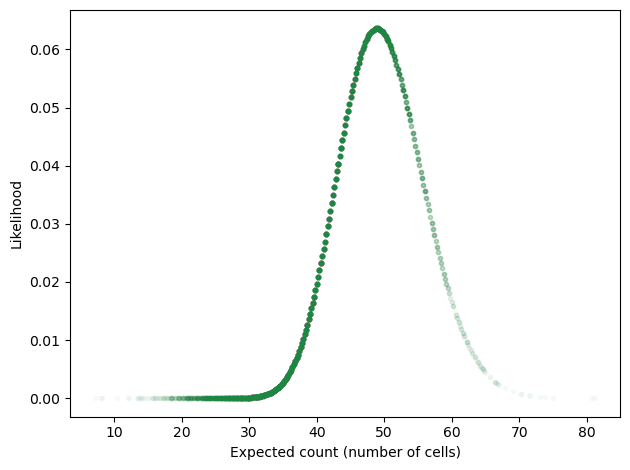

In [112]:
plt.plot(n*p, likelihood, '.', alpha=0.03, color='C2')

decorate(xlabel='Expected count (number of cells)', ylabel='Likelihood')

<br>

#### 각 가능도는 단일 시뮬레이션 결과인 `n`의 각 값에 대한 확률이기 때문에, 이 가능도는 아직 불완전 $\rightarrow$ 베이지안 갱신에 사용할 수 없음

<br>

### 데이터와 정확하게 들어맞는 시뮬레이션 결과만을 찾는 대신, 결괏값이 비슷한 경우에 가능도를 활용해서 부분점수를 부여
#### **효모 집중도 `yeast conc`를 값으로 가지고, 가능도를 정규화하지 않은 확률로 사용하는 Pmf 생성**

In [89]:
qs = prior_sample['yeast conc'] / billion
ps = likelihood
posterior_pmf = Pmf(ps, qs)

In [121]:
posterior_pmf

,probs
0.481443,0.000000e+00
0.493238,6.803643e-27
0.504958,0.000000e+00
0.569844,0.000000e+00
0.640410,2.615168e-33
...,...
3.359931,4.895745e-07
3.382914,3.204892e-06
3.403220,4.093319e-08
3.410307,3.215450e-05


<br>

#### 데이터와 가까운 결괏값을 보이는 `yeast conc`의 값은 더 높은 확률과 연결 
#### $\rightarrow$ 값을 정렬하고, 확률을 정규화 $\rightarrow$ 사후분포의 추정치
- 사후평균과 신뢰구간은 MCMC에서 구했던 것과 유사

In [120]:
posterior_pmf.sort_index(inplace=True)
posterior_pmf.normalize()

print(posterior_pmf.mean(), posterior_pmf.credible_interval(0.9)) 

2.271967103727314 [1.84572375 2.71743231]


<br>

#### 분포는 비슷하지만, MCMC의 결과에 잡음이 좀 더 많음

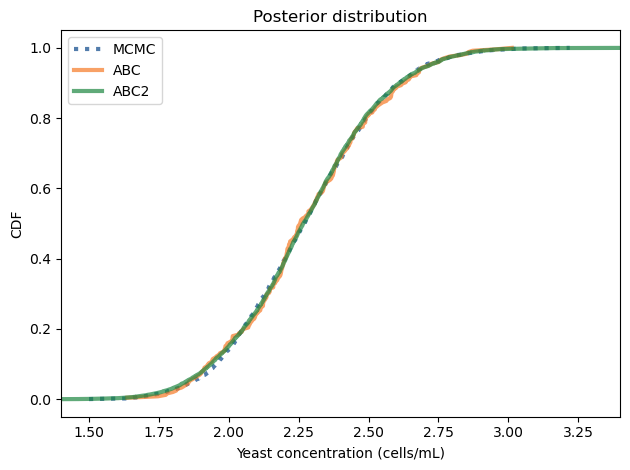

In [123]:
cdf_pymc.plot(label='MCMC', ls=':')
cdf_abc.plot(label='ABC')
posterior_pmf.make_cdf().plot(label='ABC2')

decorate(xlabel='Yeast concentration (cells/mL)', ylabel='CDF', title='Posterior distribution', xlim=(1.4, 3.4))

<br>

## 20.10. 예제

<br>

### (1)



#### [라스무스 보트의 블로그](http://www.sumsar.net/blog/2014/10/tiny-data-and-the-socks-of-karl-broman)의 글

> 세탁기에서 꺼낸 처음 11개의 양말이 구별된다면, 이는 양말이 많다는 뜻이다

**세탁기에서 11개의 양말을 꺼내서 이 중 어떤 두 양말도 쌍을 이루지 못한다는 걸 알게 되었을 떄, 이 떄 세탁기 안의 양말의 수를 계산**

<br>

####  다음의 가정을 기반

* 세탁기에는 `n_pairs`개의 양말 쌍에 `n_odd`개의 짝이 없는 양말이 있다

* 양말 쌍의 모양은 각각 다르고 한 짝만 있는 양말과도 서로 다름. 즉, 각 모양의 양말은 1개 혹은 2개만 있음

#### 보트가 제안한 사전분포

* 양말 수는 평균 30에 표준편차 15인 음의 이항분포를 따름

* 양말 쌍의 비율은 $\alpha=15$이고, $\beta=2$인 베타분포를 따름


<br>

#### 양말 수, 양말 쌍의 비율의 사전분포

In [124]:
from scipy.stats import nbinom, beta

In [141]:
mu = 30
p = 0.8666666
r = mu * (1-p) / p

prior_n_socks = nbinom(r, 1-p)
prior_n_socks.mean(), prior_n_socks.std()

(30.0, 14.999996250001402)

In [93]:
prior_prop_pair = beta(15, 2)
prior_prop_pair.mean()

0.8823529411764706

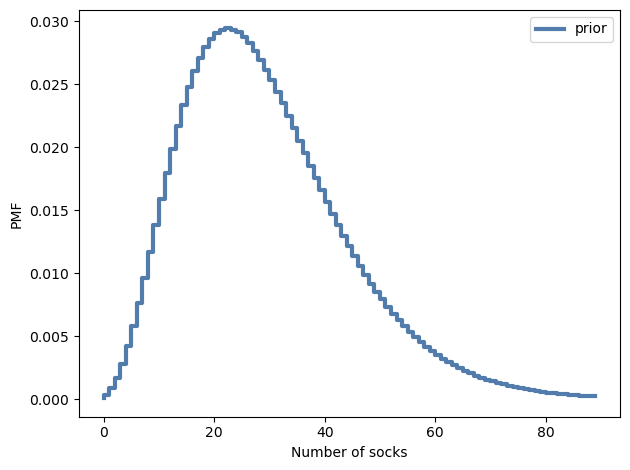

In [94]:
qs = np.arange(90)
ps = prior_n_socks.pmf(qs)
pmf = Pmf(ps, qs)
pmf.normalize()

pmf.plot(label='prior', drawstyle='steps')

decorate(xlabel='Number of socks', ylabel='PMF')

In [126]:
from utils import pmf_from_dist

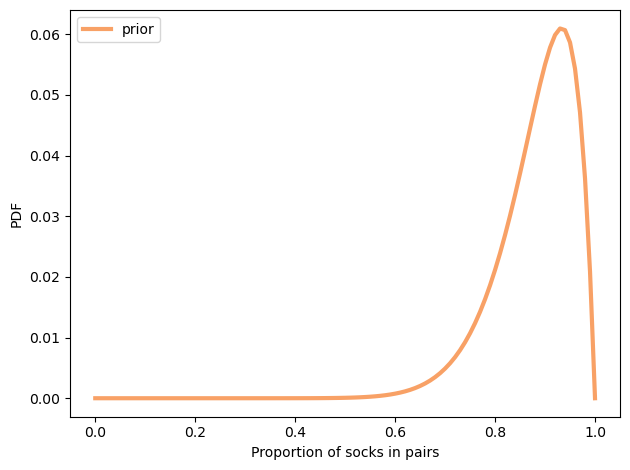

In [127]:
qs = np.linspace(0, 1, 101)
pmf = pmf_from_dist(prior_prop_pair, qs)
pmf.plot(label='prior', color='C1')

decorate(xlabel='Proportion of socks in pairs', ylabel='PDF')

<br>

#### 사전분포 표본추출

In [142]:
n_socks = prior_n_socks.rvs()
prop_pairs = prior_prop_pair.rvs()

n_socks, prop_pairs

(23, 0.8420529547086186)

#### `n_pairs` and `n_odds`값 계산

In [143]:
n_pairs = np.round(n_socks//2 * prop_pairs)
n_odds = n_socks - n_pairs*2

n_pairs, n_odds

(9.0, 5.0)

<br>

#### 9개의 양말 쌍과, 5개의 짝이 없는 양말

In [144]:
socks = np.append(np.arange(n_pairs),  np.arange(n_pairs + n_odds))

print(socks)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10. 11. 12. 13.]


<br>

#### 9개의 양말 쌍과, 5개의 짝이 없는 양말이 든 세탁기에서, 11개의 양말을 꺼냄

In [129]:
picked_socks = np.random.choice(socks, size=11, replace=False)
picked_socks

array([ 1, 10, 11,  6,  7,  0,  4,  6,  8,  5, 12])

<br>

#### 세탁기에서 꺼낸 11개의 양말 중, 6번 양말만 1개만 쌍을 이루며 나머지 9개는 아직 세탁기 안에 존재

In [146]:
values, counts = np.unique(picked_socks, return_counts=True)
values, counts

(array([ 0,  1,  4,  5,  6,  7,  8, 10, 11, 12]),
 array([1, 1, 1, 1, 2, 1, 1, 1, 1, 1], dtype=int64))

In [147]:
solo = np.sum(counts==1)
pairs = np.sum(counts==2)

solo, pairs

(9, 1)

<br>

### 세탁기에서 양말 11개를 꺼내는 과정을 시뮬레이션

In [148]:
def pick_socks(n_pairs, n_odds, n_pick):
    socks = np.append(np.arange(n_pairs), np.arange(n_pairs + n_odds))
    
    picked_socks = np.random.choice(socks, size=n_pick, replace=False)
    
    values, counts = np.unique(picked_socks, return_counts=True)
    pairs = np.sum(counts==2)
    odds = np.sum(counts==1)
    return pairs, odds

In [154]:
pick_socks(n_pairs, n_odds, 11)

(2, 7)

<br>

#### 10,000번의 시뮬레이션 중, 세탁기에서 짝이 없는 양말만 11개가 나오는 (어떠한 양말쌍도 나오지 않음) 경우 1,153개

In [155]:
data = (0, 11)
res = []

for i in range(10000):
    
    n_socks = prior_n_socks.rvs()
    
    if n_socks < 11:
        continue
        
    prop_pairs = prior_prop_pair.rvs()
    n_pairs = np.round(n_socks//2 * prop_pairs)
    n_odds = n_socks - n_pairs*2
    result = pick_socks(n_pairs, n_odds, 11)
    
    if result == data:
        res.append((n_socks, n_pairs, n_odds))

len(res)

1153

In [151]:
columns = ['n_socks', 'n_pairs', 'n_odds']
results = pd.DataFrame(res, columns=columns)
results.head()

,n_socks,n_pairs,n_odds
0,62,29.0,4.0
1,32,10.0,12.0
2,30,11.0,8.0
3,38,16.0,6.0
4,22,7.0,8.0


<br>

#### 세탁기 안의 양말 `n_socks`의 사후분포의 평균 & 90% 신용구간

In [137]:
qs = np.arange(15, 100)
posterior_n_socks = Pmf.from_seq(results['n_socks'])

print(posterior_n_socks.median(), posterior_n_socks.credible_interval(0.9))

44.0 [27. 74.]


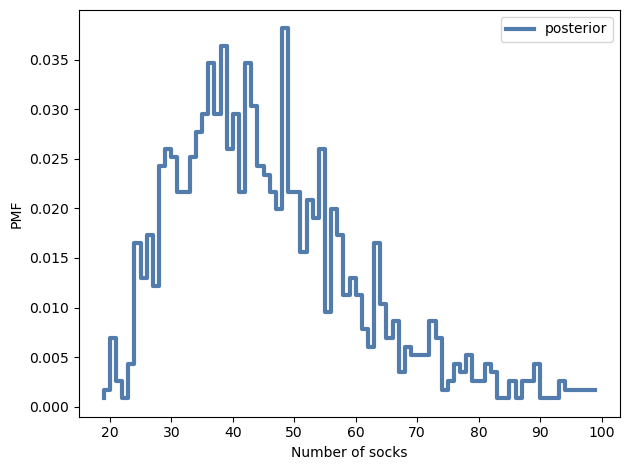

In [138]:
posterior_n_socks.plot(label='posterior', drawstyle='steps')

decorate(xlabel='Number of socks', ylabel='PMF')